## Imports

In [16]:
import sys
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import ConcatDataset, DataLoader, Subset

sys.path.insert(0, '../')
from src.rfc_dataset import RFCDataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Import data

In [3]:
data = RFCDataset(
    data_dir="../data/ribfrac-challenge/training/prepared/pos",
)

Let's take a look at one particular fracture. A quick search through data above shows that these are a set of 2D slices that have a fracture in them.

In [13]:
# sorted([path for path in data.paths if 'RibFrac100' in str(path)])
slice_nums = list(range(156, 171))
str_paths = [str(path) for path in data.paths]

pre = '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_'
str_targets = [pre + str(i) + '.pt.gz' for i in range(110, 127 + 1)]
fx_inds = [i for i, path in enumerate(str_paths) if path in str_targets]

slices = torch.zeros((len(fx_inds), 512, 512))
labels = torch.zeros((len(fx_inds), 512, 512))
for i, ind in enumerate(tqdm(fx_inds)):
    ds = data.__getitem__(ind)
    slices[i, ...] = ds['image'][0, ...]
    labels[i, ...] = ds['label'][0, ...]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


In [37]:
print(str_targets)

['../data/ribfrac-challenge/training/prepared/pos/RibFrac100_110.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_111.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_112.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_113.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_114.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_115.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_116.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_117.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_118.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_119.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_120.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_121.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_122.pt.gz', '../data/ribfrac-challenge/training/prepared/pos/RibFrac100_123

In [34]:
labels[0, ...].unique()

tensor([1.])

In [36]:
print((labels[0, ...] != 1).sum())

tensor(0)


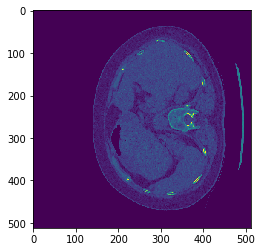

In [27]:
plt.figure()
plt.imshow(slices[0, ...])

### Select one image to start

In [31]:
dp = data.__getitem__(0)
dp['label'].unique()

tensor([1, 4])


In [28]:
data.paths

AttributeError: 'Subset' object has no attribute 'paths'

In [26]:
dp['label'].unique()

tensor([0, 1])